<a href="https://colab.research.google.com/github/elifsare/IBM-HR-Analytics-Employee-Attrition-Performance/blob/main/Employee_Attrition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import requirements

## Import Data

Fetching data using Kaggle API key.

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d pavansubhasht/ibm-hr-analytics-attrition-dataset

In [ ]:
!unzip '/content/ibm-hr-analytics-attrition-dataset.zip' -d dataset

## Import Libraries

In [ ]:
!pip install catboost

In [ ]:
!pip install -U imbalanced-learn

In [6]:
import pandas as pd
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# Exploring The Dataset

In [7]:
data = pd.read_csv("/content/dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv")

In [8]:
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [10]:
shape = data.shape
num_rows, num_columns = shape
size = data.size

print("Shape (rows, columns):", shape)
print("Number of columns:", num_columns)
print("Size of the dataset:", size)

Shape (rows, columns): (1470, 35)
Number of columns: 35
Size of the dataset: 51450


## Find the duplicated values

In [11]:
data.duplicated().any()

False

## Find the missing values

In [12]:
data.isna().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

In [13]:
for column in data.columns:
    print(f"{column}: Number of unique values {data[column].nunique()} \n")

Age: Number of unique values 43 

Attrition: Number of unique values 2 

BusinessTravel: Number of unique values 3 

DailyRate: Number of unique values 886 

Department: Number of unique values 3 

DistanceFromHome: Number of unique values 29 

Education: Number of unique values 5 

EducationField: Number of unique values 6 

EmployeeCount: Number of unique values 1 

EmployeeNumber: Number of unique values 1470 

EnvironmentSatisfaction: Number of unique values 4 

Gender: Number of unique values 2 

HourlyRate: Number of unique values 71 

JobInvolvement: Number of unique values 4 

JobLevel: Number of unique values 5 

JobRole: Number of unique values 9 

JobSatisfaction: Number of unique values 4 

MaritalStatus: Number of unique values 3 

MonthlyIncome: Number of unique values 1349 

MonthlyRate: Number of unique values 1427 

NumCompaniesWorked: Number of unique values 10 

Over18: Number of unique values 1 

OverTime: Number of unique values 2 

PercentSalaryHike: Number of uni

# Feature Engineering


We did not perform any operations on the dataset as there were no missing values; however, if there were any, we should have applied one of the following procedures:
*   Data Imputation: Various methods can be employed to fill in missing data. For instance, filling with statistical values such as mean, median, or mode.

* Interpolation and Extrapolation: To predict missing values, we could have utilized interpolation (estimating missing values between existing data points) or extrapolation (predicting future values using existing data).

* Handling Missing Data / Separation for Testing: If the amount of missing data is minimal and wouldn't impact the analysis, we could have considered deleting the missing values. However, this approach should be used cautiously as it often leads to data loss.

<br>

For the absence of duplicated values in the dataset, we did not perform any operations; however, if there were any, we should have applied one of the following procedures:
*  Removing Duplicated Values: If duplicated values were present and would negatively impact the analysis, considering the removal of these values would have been an option. Nevertheless, caution should be exercised, and the importance of the data should be assessed before deciding to delete.

In [59]:
df =pd.DataFrame(data)

We discard entries with a low count of unique values as they are not useful for our analysis. Of course, excluding data like gender or department :)


In [60]:
df.drop(['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours'], axis="columns", inplace=True)

In [61]:
categorical_columns = df.select_dtypes(include=['object']).columns.difference(['Attrition'])

print("\nCategorical Columns:")
print(categorical_columns)

from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
df["Attrition"] = label.fit_transform(df.Attrition)


Categorical Columns:
Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'OverTime'],
      dtype='object')


## one-hot encoding for categorical columns

In [ ]:
# Kategorik sütunları one-hot encoding uygula
df_encoded = pd.get_dummies(df[categorical_columns], columns=categorical_columns, drop_first=True)
print(df_encoded)

df = df.drop(categorical_columns, axis=1)

In [63]:
df.columns

Index(['Age', 'Attrition', 'DailyRate', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel',
       'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')

In [64]:
df_encoded.columns

Index(['BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely',
       'Department_Research & Development', 'Department_Sales',
       'EducationField_Life Sciences', 'EducationField_Marketing',
       'EducationField_Medical', 'EducationField_Other',
       'EducationField_Technical Degree', 'Gender_Male',
       'JobRole_Human Resources', 'JobRole_Laboratory Technician',
       'JobRole_Manager', 'JobRole_Manufacturing Director',
       'JobRole_Research Director', 'JobRole_Research Scientist',
       'JobRole_Sales Executive', 'JobRole_Sales Representative',
       'MaritalStatus_Married', 'MaritalStatus_Single', 'OverTime_Yes'],
      dtype='object')

In [65]:
# We merge df_encoded and df to obtain a single dataset again.
df_combined = pd.concat([df, df_encoded], axis=1)

In [66]:
df_combined.columns

Index(['Age', 'Attrition', 'DailyRate', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel',
       'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely',
       'Department_Research & Development', 'Department_Sales',
       'EducationField_Life Sciences', 'EducationField_Marketing',
       'EducationField_Medical', 'EducationField_Other',
       'EducationField_Technical Degree', 'Gender_Male',
       'JobRole_Human Resources', 'JobRole_Laboratory Technician',
       'JobRole_Manager', 'JobRole_Manufacturing Director',
       'JobRole_Research Director', 'JobRole_Res

# Data Visulation

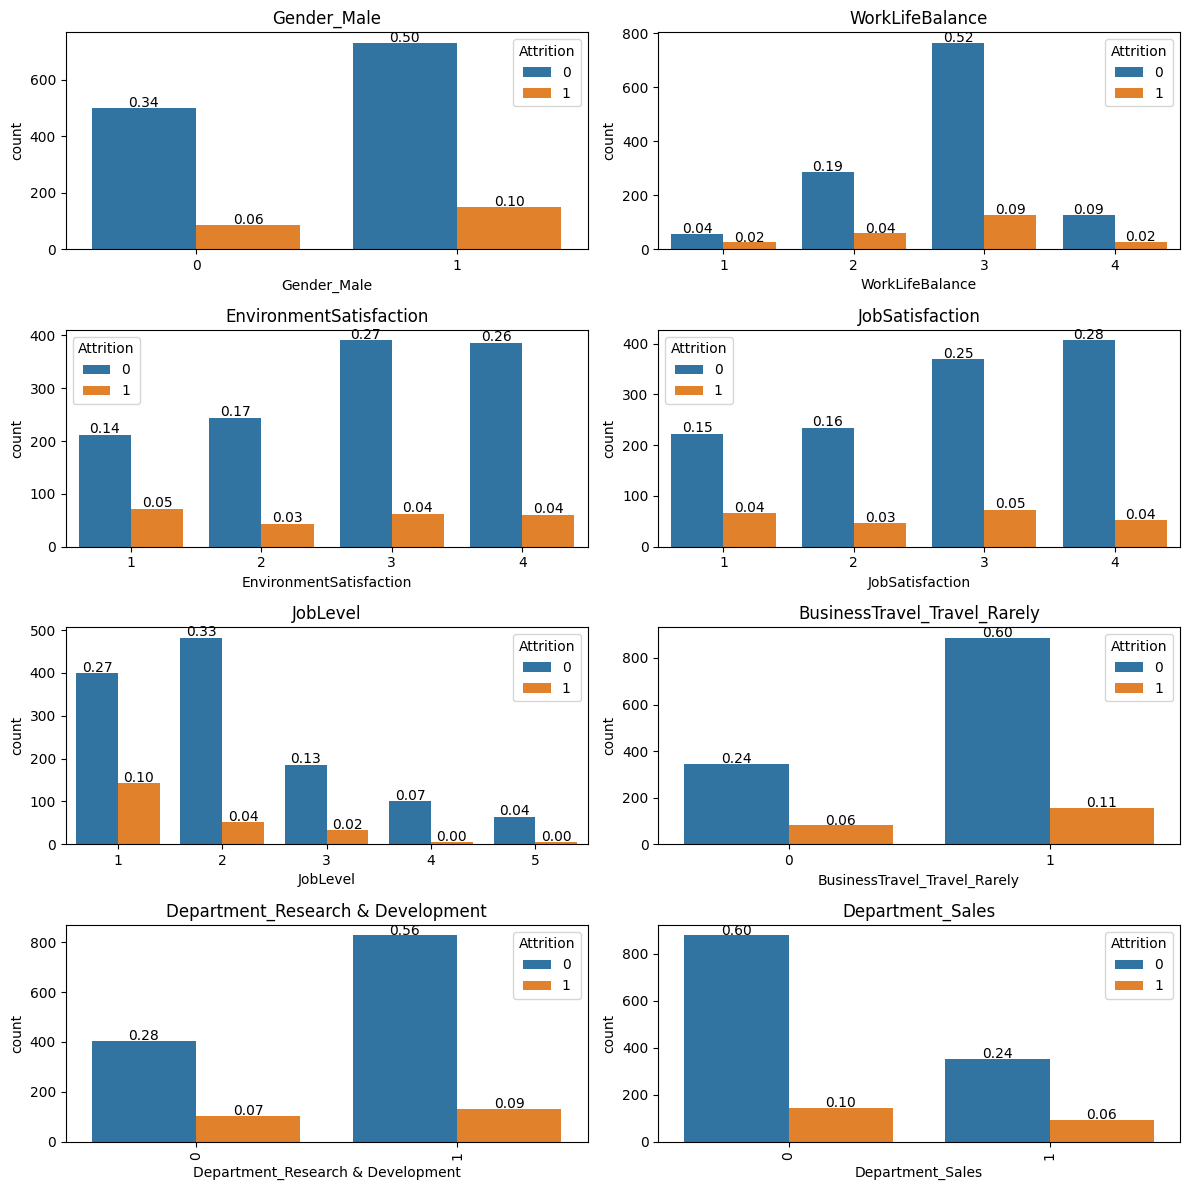

In [67]:
total_records = len(df_combined)
columns = ["Gender_Male","WorkLifeBalance","EnvironmentSatisfaction","JobSatisfaction",
           "JobLevel","BusinessTravel_Travel_Rarely",'Department_Research & Development',
           'Department_Sales','JobRole_Human Resources', 'JobRole_Laboratory Technician',
           'JobRole_Manager', 'JobRole_Manufacturing Director',
           'JobRole_Research Director', 'JobRole_Research Scientist',
           'JobRole_Sales Executive', 'JobRole_Sales Representative',
           'MaritalStatus_Married', 'MaritalStatus_Single']

fig, axes = plt.subplots(4, 2, figsize=(12, 12))
axes = axes.flatten()

for ax, column in zip(axes, columns):
    sns.countplot(data=df_combined, x=column, hue="Attrition", ax=ax)
    ax.set_title(column)
    if ax in [axes[-1], axes[-2]]:  # Rotate x-axis labels for the last two subplots
        ax.tick_params(axis='x', rotation=90)

    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 3, '{:1.2f}'.format(height / total_records, 0),
                ha="center", rotation=0)

plt.tight_layout()
plt.show()


## correlation_matrix

<Axes: >

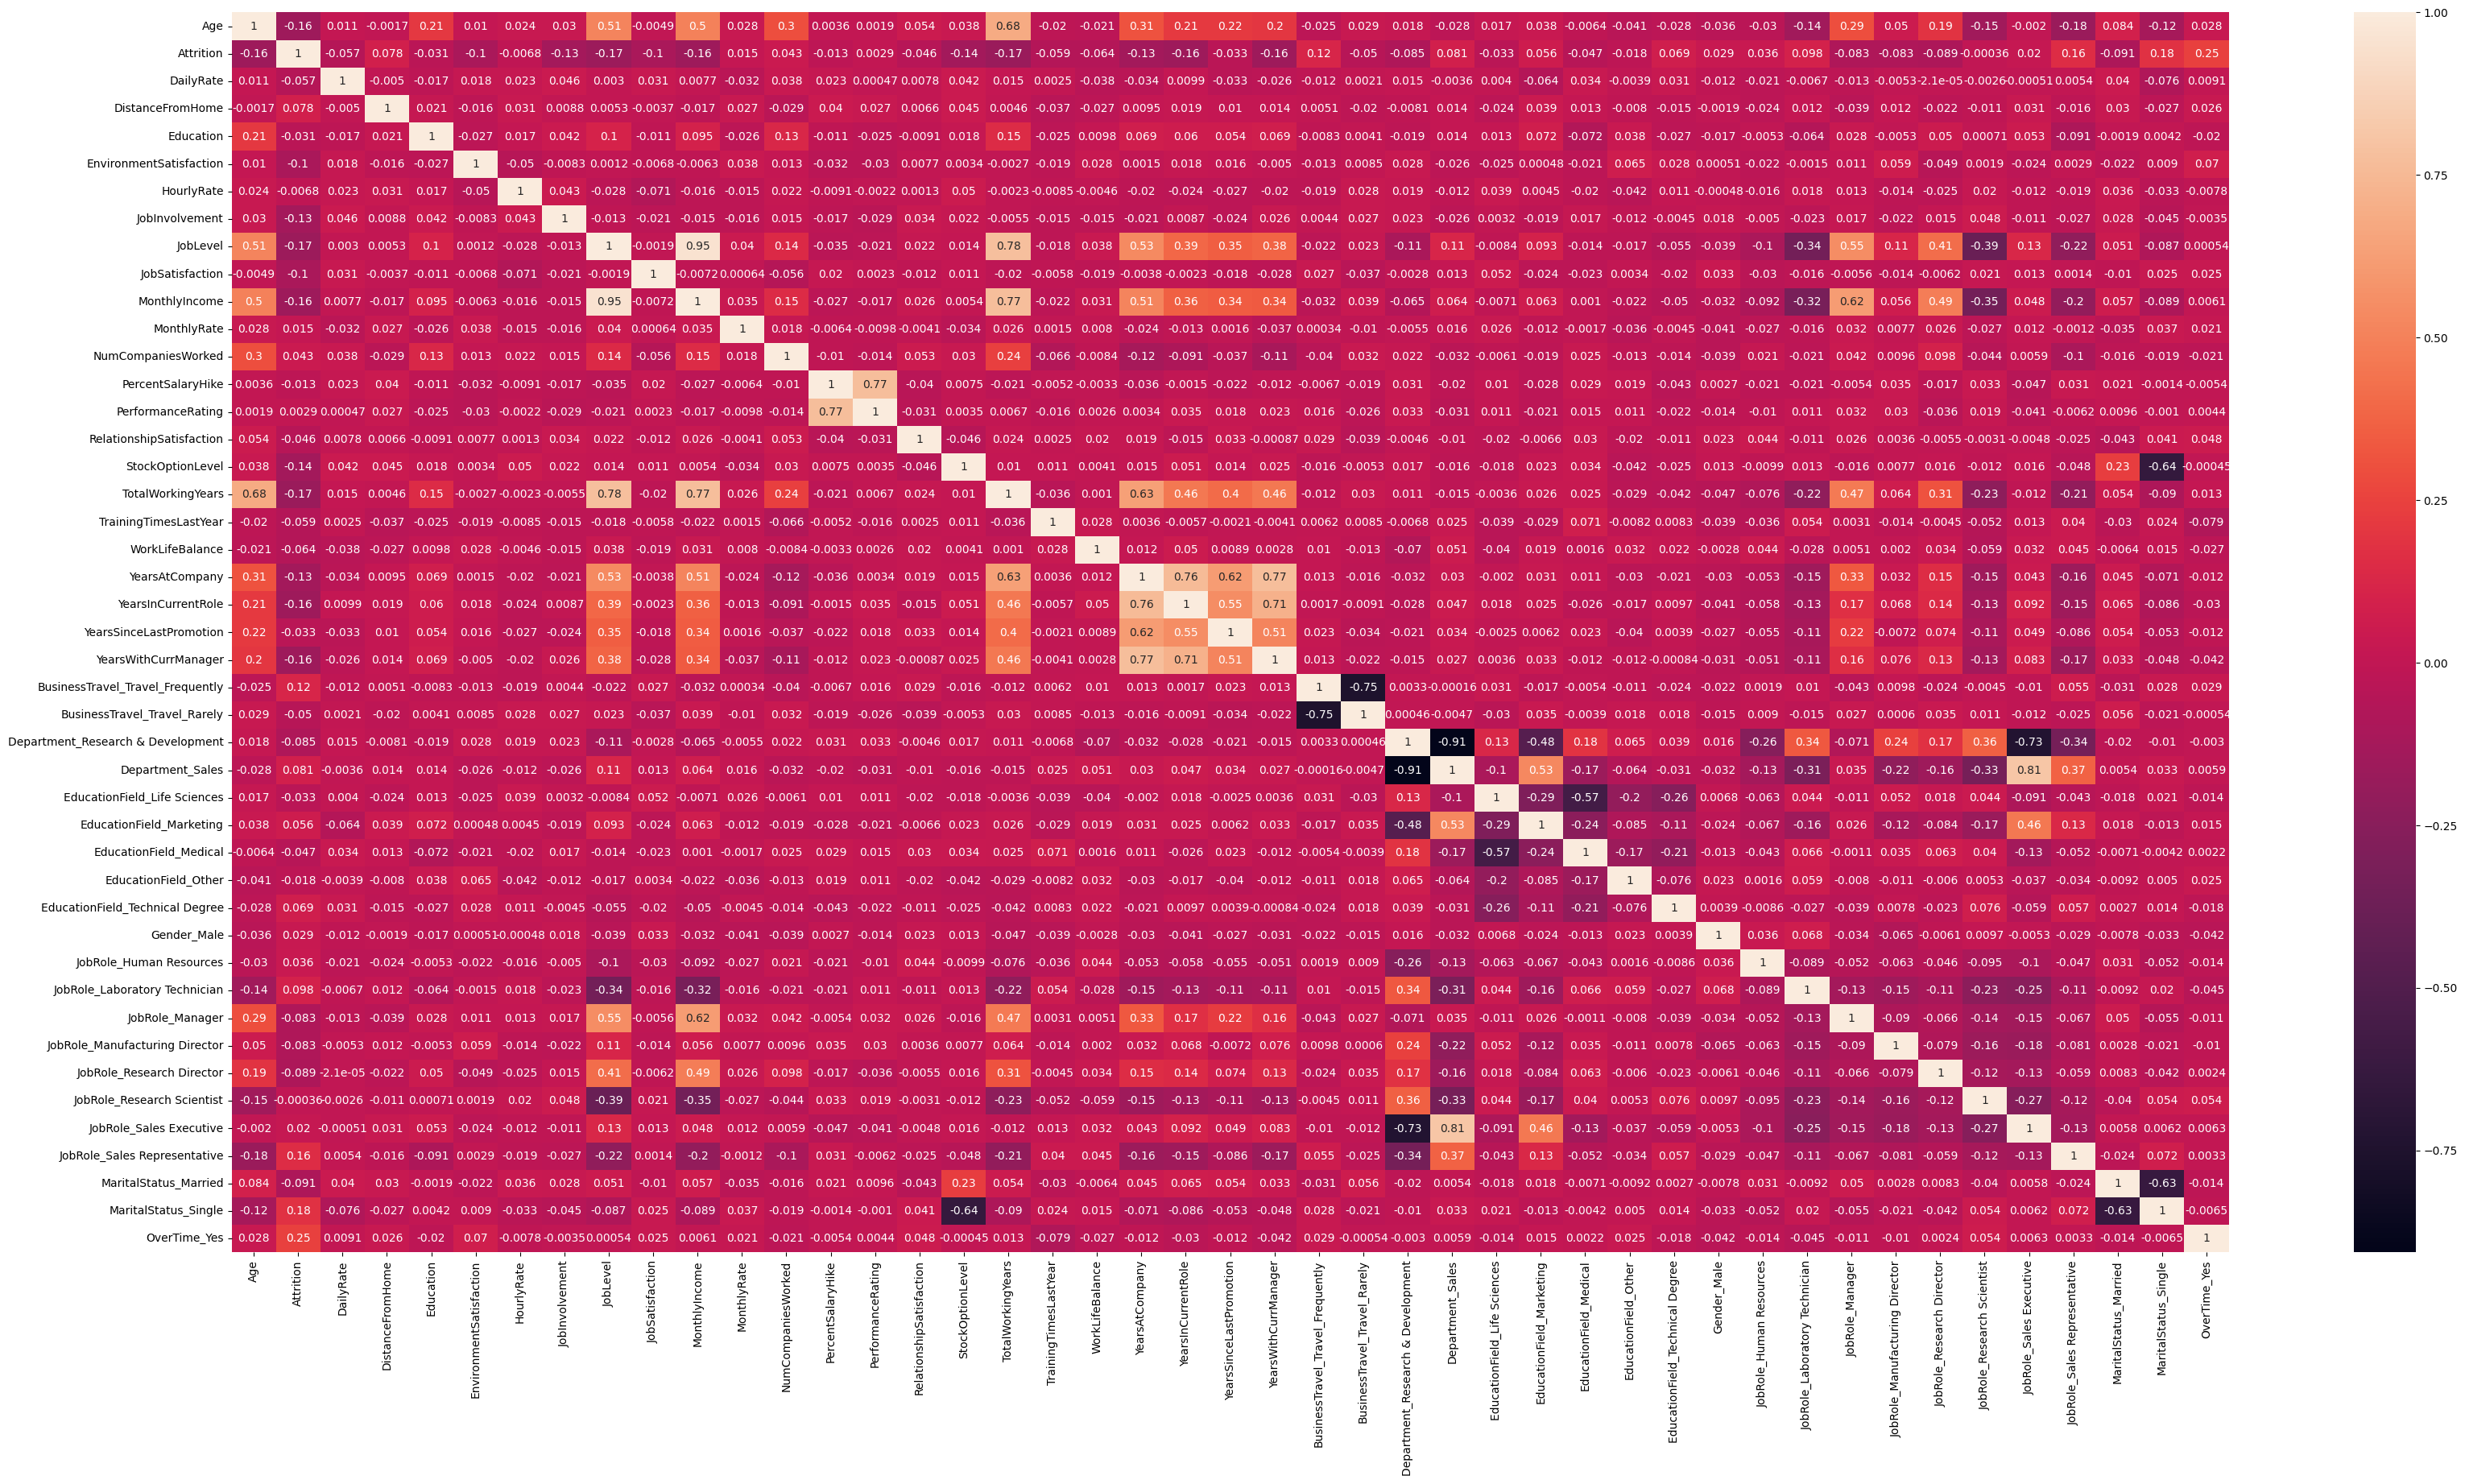

In [68]:
correlation_matrix = df_combined.corr()
plt.figure(figsize=(40,20))
sns.heatmap(correlation_matrix, annot=True)

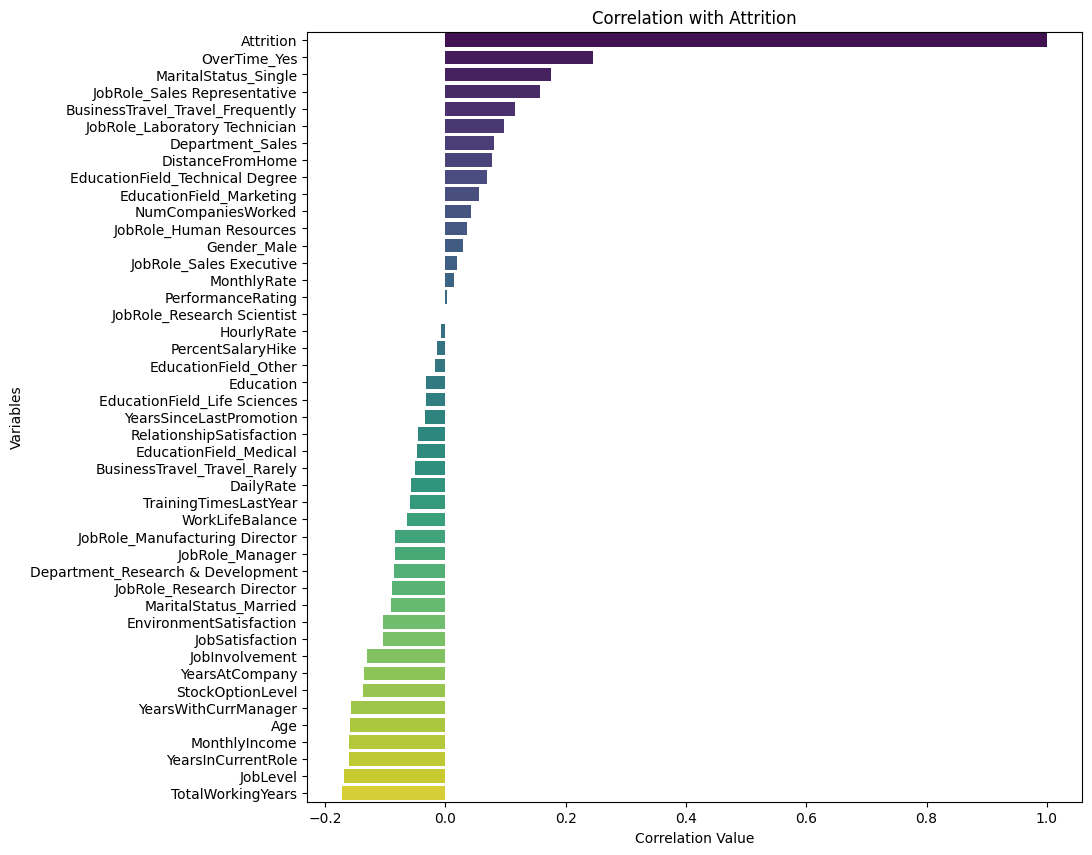

In [69]:
attrition_correlation = correlation_matrix['Attrition']

correlation_df = pd.DataFrame({'Variable': attrition_correlation.index, 'Correlation': attrition_correlation.values})

correlation_df = correlation_df.sort_values(by='Correlation', ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(x='Correlation', y='Variable', data=correlation_df, palette='viridis')

plt.title('Correlation with Attrition')
plt.xlabel('Correlation Value')
plt.ylabel('Variables')
plt.show()


<Axes: xlabel='Attrition', ylabel='count'>

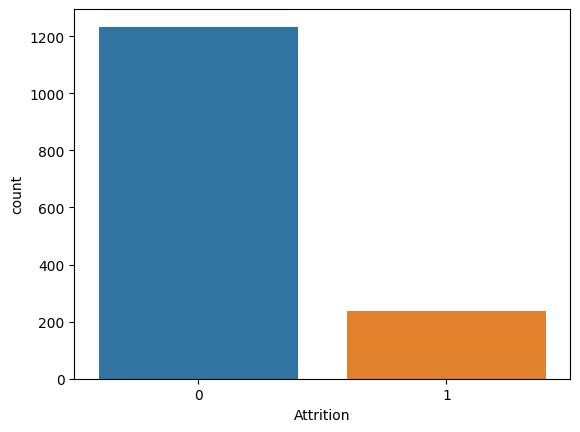

In [70]:
sns.countplot(x='Attrition', data=df)

As seen in the graph, we have an imbalanced dataset.


# Model Training

In [71]:
X = df_combined.drop('Attrition', axis=1)
y = df_combined['Attrition']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [72]:
Counter(y_train)

Counter({0: 978, 1: 198})

In [73]:
# We are generating synthetic data using SMOTE due to the imbalanced nature of the dataset.
# We apply it only to the training set.

smote = SMOTE(random_state=42, sampling_strategy = 0.5)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [74]:
Counter(y_train_resampled)

Counter({0: 978, 1: 489})

In [75]:
def train_and_evaluate_model(model_name, model, X_train, X_test, y_train, y_test, cv=10, metrics=None):

    if metrics is None:
        metrics = ['accuracy', 'precision', 'recall', 'f1']

    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    results = {
        'model': model_name,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'cv_scores': cv_scores
    }

    return results

In [76]:
def model_evaluation_plotter(model_name, model, X_test, y_test, figsize=(20, 5)):
    y_scores = model.predict_proba(X_test)[:, 1]

    plt.figure(figsize=figsize)

    # Confusion Matrix
    plt.subplot(1, 3, 1)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='g', xticklabels=['0', '1'], yticklabels=['0', '1'], cmap=sns.cubehelix_palette(as_cmap=True))
    plt.ylabel('Actual', fontsize=13)
    plt.xlabel('Prediction', fontsize=13)
    plt.title(f"{model_name} Confusion Matrix")

    # ROC curve
    plt.subplot(1, 3, 2)
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"{model_name} ROC Curve")
    plt.legend(loc='lower right')

    # Precision - Recall
    plt.subplot(1, 3, 3)
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    average_precision = average_precision_score(y_test, y_scores)
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f"{model_name} Precision-Recall Curve: AP={0:0.2f}".format(average_precision))

    plt.show()

In [77]:
rf = RandomForestClassifier(random_state=42, class_weight = 'balanced')
train_and_evaluate_model('Random Forest', rf, X_train_resampled, X_test, y_train_resampled, y_test)

{'model': 'Random Forest',
 'accuracy': 0.8775510204081632,
 'precision': 0.6363636363636364,
 'recall': 0.1794871794871795,
 'f1': 0.28,
 'cv_scores': array([0.69387755, 0.7755102 , 0.78231293, 0.7414966 , 0.95918367,
        0.96598639, 0.97959184, 0.95205479, 0.95890411, 0.96575342])}

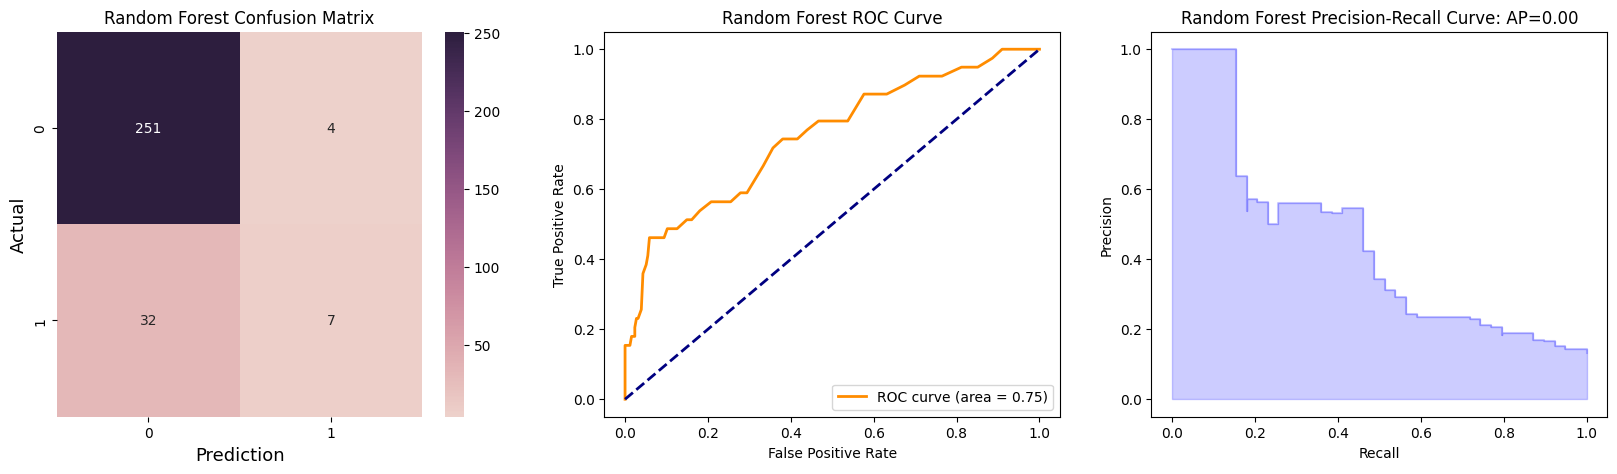

In [78]:
model_evaluation_plotter('Random Forest', rf, X_test, y_test)

In [79]:
XGB = XGBClassifier(random_state=42, scale_pos_weight=5)
train_and_evaluate_model('XGBClassifier', XGB, X_train_resampled, X_test, y_train_resampled, y_test)

{'model': 'XGBClassifier',
 'accuracy': 0.8469387755102041,
 'precision': 0.4,
 'recall': 0.3076923076923077,
 'f1': 0.34782608695652173,
 'cv_scores': array([0.78911565, 0.78231293, 0.82312925, 0.78911565, 0.95918367,
        0.92517007, 0.97278912, 0.91780822, 0.93835616, 0.93835616])}

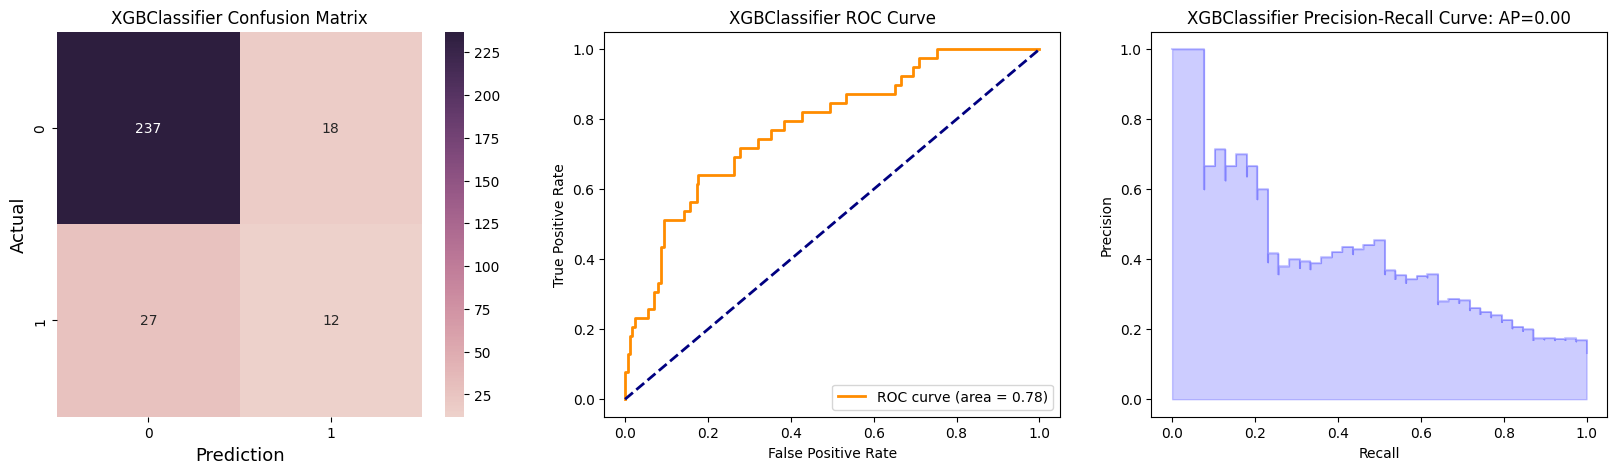

In [80]:
model_evaluation_plotter('XGBClassifier', XGB, X_test, y_test)

In [81]:
SVM = SVC(class_weight='balanced', random_state=42, probability=True)
train_and_evaluate_model('SVM', SVM, X_train_resampled, X_test, y_train_resampled, y_test)

{'model': 'SVM',
 'accuracy': 0.5544217687074829,
 'precision': 0.17142857142857143,
 'recall': 0.6153846153846154,
 'f1': 0.2681564245810056,
 'cv_scores': array([0.5170068 , 0.57823129, 0.58503401, 0.58503401, 0.52380952,
        0.4829932 , 0.58503401, 0.5       , 0.51369863, 0.57534247])}

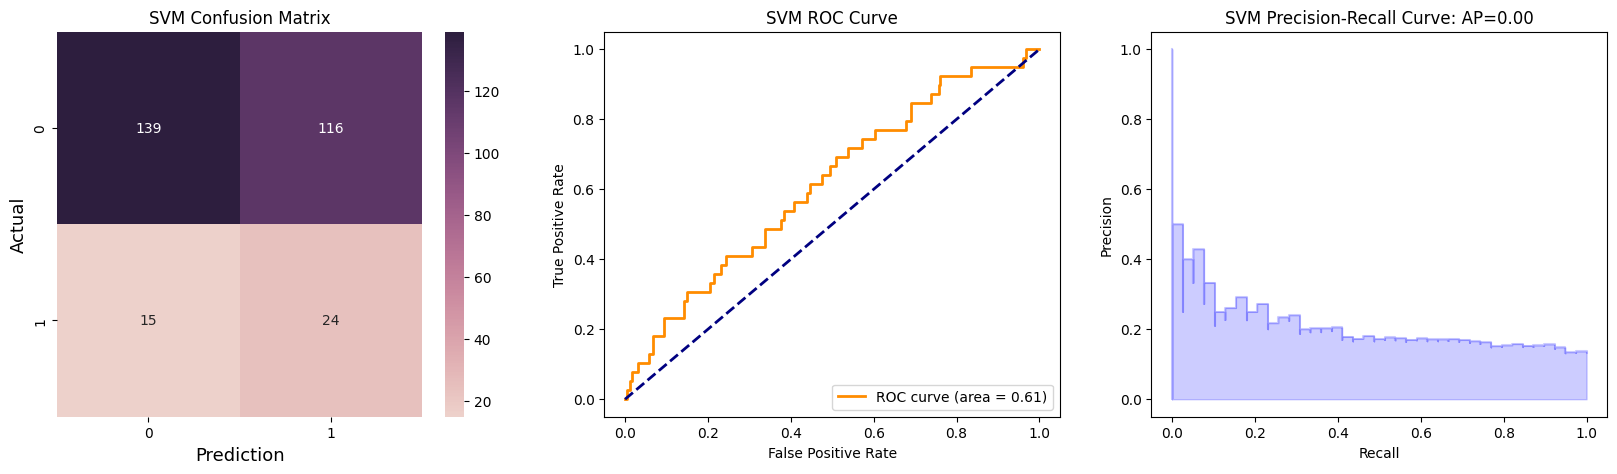

In [82]:
model_evaluation_plotter('SVM', SVM, X_test, y_test)

In [83]:
CatB = CatBoostClassifier(iterations=500, learning_rate=0.01, depth=6, loss_function='MultiClass', verbose=False, random_state=42)
train_and_evaluate_model('Cat Boost', CatB, X_train_resampled, X_test, y_train_resampled, y_test)

{'model': 'Cat Boost',
 'accuracy': 0.8809523809523809,
 'precision': 0.5909090909090909,
 'recall': 0.3333333333333333,
 'f1': 0.4262295081967213,
 'cv_scores': array([0.7414966 , 0.78231293, 0.76870748, 0.78231293, 0.92517007,
        0.92517007, 0.93197279, 0.88356164, 0.94520548, 0.91780822])}

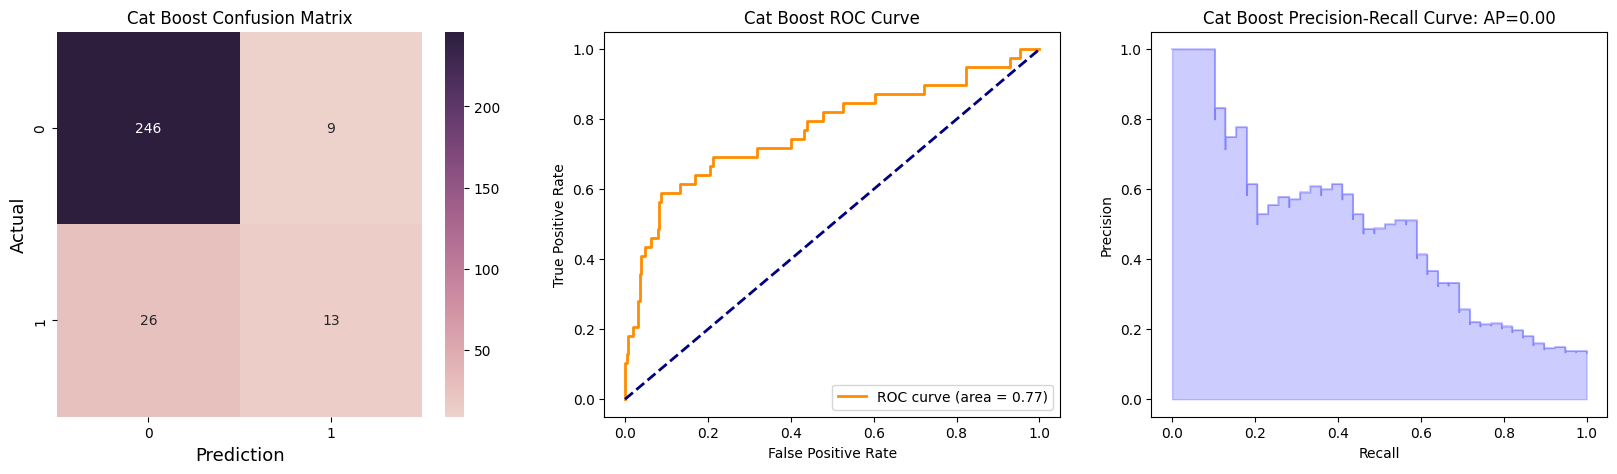

In [84]:
model_evaluation_plotter('Cat Boost', CatB, X_test, y_test)

In [85]:
LR = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000, solver = "newton-cholesky")
train_and_evaluate_model('Logistic Regression', LR, X_train_resampled, X_test, y_train_resampled, y_test)

{'model': 'Logistic Regression',
 'accuracy': 0.8367346938775511,
 'precision': 0.42105263157894735,
 'recall': 0.6153846153846154,
 'f1': 0.5,
 'cv_scores': array([0.75510204, 0.78911565, 0.78911565, 0.7755102 , 0.91836735,
        0.89795918, 0.89115646, 0.85616438, 0.93150685, 0.88356164])}

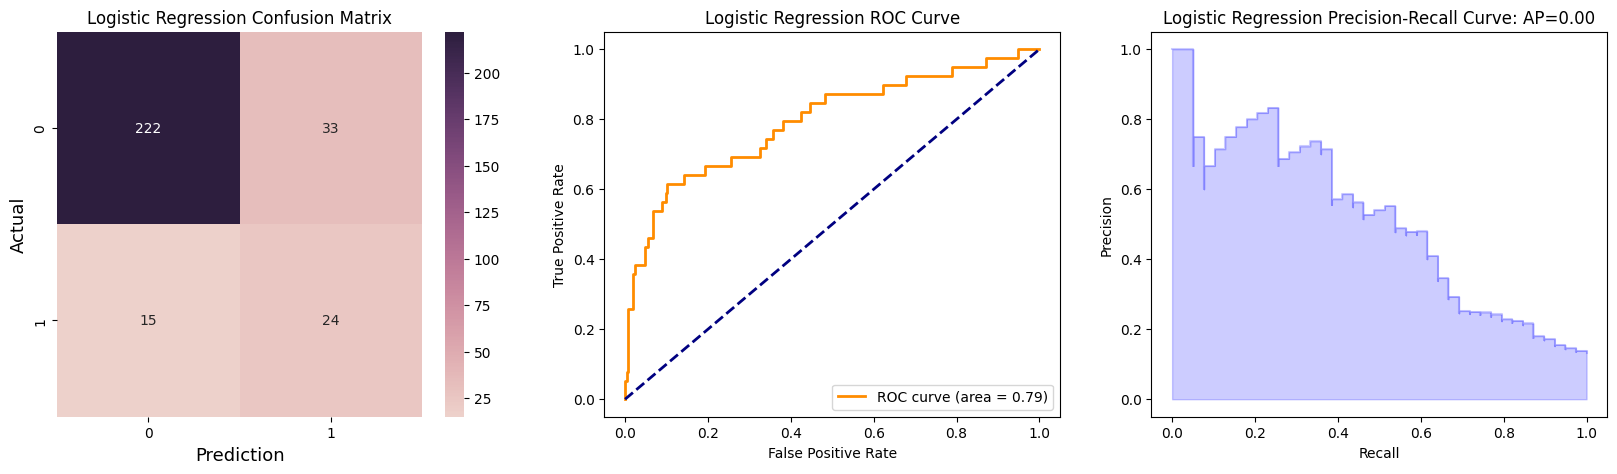

In [86]:
model_evaluation_plotter('Logistic Regression', LR, X_test, y_test)

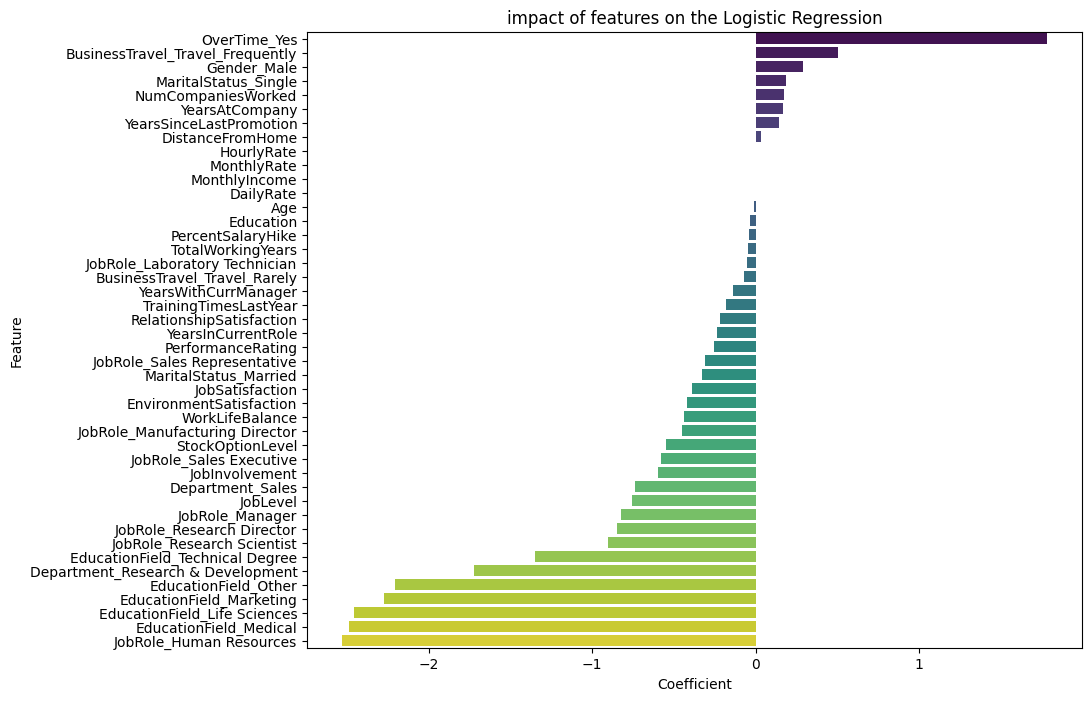

In [87]:
coefficients_df = pd.DataFrame({'Feature': X_train_resampled.columns, 'Coefficient': LR.coef_[0]})
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=coefficients_df,palette= 'viridis')
plt.title('impact of features on the Logistic Regression')
plt.show()